In [1]:
import cv2
import tensorflow as tf
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import ssl
import seaborn as sns
from pylab import rcParams

In [2]:
ssl._create_default_https_context = ssl._create_unverified_context

### Dividing closed/open eyes by 0/1 in file name from dataset

In [3]:
main_dir = "mrlEyes_2018_01"
open_folder = "train_2/opened_eyes"
close_folder = "train_2/closed_eyes"

os.makedirs(open_folder, exist_ok=True)
os.makedirs(close_folder, exist_ok=True)

folder_map = {'1': open_folder, '0': close_folder}

# Traverse through each subfolder in the main directory
for subfolder in os.listdir(main_dir):
    subfolder_path = os.path.join(main_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            if filename.endswith(".png"):
                parts = filename.split('_')
                # Get open or close eyes
                destination = folder_map.get(parts[4], None)
                if destination:
                    file_path = os.path.join(subfolder_path, filename)
                    # Copy the file to the destination folder
                    shutil.copy(file_path, os.path.join(destination, filename))

print("Files have been copied successfully.")

Files have been copied successfully.


In [2]:
# Deleting some files for fast training
main_folder = 'train_2' 
subfolders = ['closed_eyes', 'opened_eyes']

for subfolder in subfolders:
    subfolder_path = os.path.join(main_folder, subfolder)
    files = os.listdir(subfolder_path)

    selected_files = files[:3000]
    files_to_remove = set(files[3000:])
    
    for file_name in files_to_remove:
        file_path = os.path.join(subfolder_path, file_name)
        os.remove(file_path)
        
    print(f"Processed {subfolder}, kept {len(selected_files)} files, removed {len(files_to_remove)} files.")

Processed closed_eyes, kept 3000 files, removed 7000 files.
Processed opened_eyes, kept 3000 files, removed 7000 files.


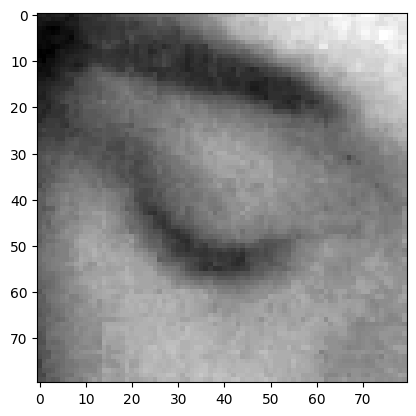

In [3]:
img_array = cv2.imread("train_2/closed_eyes/s0001_00799_0_0_0_0_0_01.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img_array, cmap="gray")

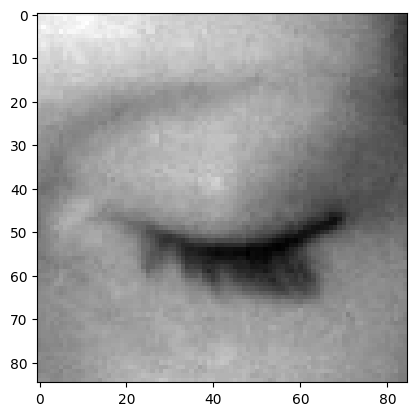

In [4]:
DataDirectory = "train_2/"
classes = ["closed_eyes", "opened_eyes"]
for category in classes:
    path = os.path.join(DataDirectory, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
        plt.imshow(img_array, cmap="gray")
        plt.show()
        break
    break

### Image data preprocessing

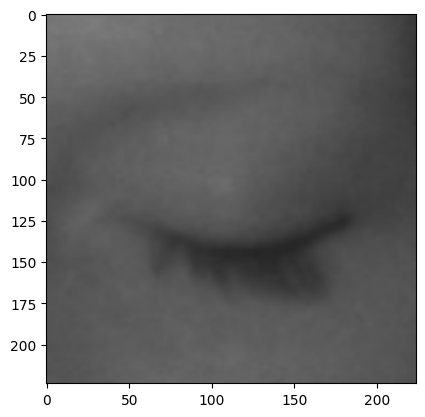

In [5]:
img_size = 224
new_array = cv2.resize(backtorgb, (img_size, img_size))
plt.imshow(new_array, cmap="gray")
plt.show()

In [6]:
train_df = []

def create_training_data():
    for category in classes:
        path = os.path.join(DataDirectory, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                backtoggb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
                new_array = cv2.resize(backtoggb, (img_size, img_size))
                train_df.append([new_array, class_num])
            except Exception as e:
                pass

In [7]:
create_training_data()
random.shuffle(train_df)

In [8]:
X = []
y = []
for features, label in train_df:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3)
X.shape

(6000, 224, 224, 3)

In [11]:
X = X / 255.0
Y = np.array(y)
Y = to_categorical(Y, num_classes=2)

### Model initialisation and training

In [13]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [14]:
# Transfer learning

base_input = model.input
base_output = model.layers[-4].output

In [15]:
base_input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [16]:
flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(2, activation='softmax')(flat_layer)

In [17]:
modified_model = keras.Model(inputs=base_input, outputs=final_output)
modified_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [18]:
modified_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [19]:
history = modified_model.fit(X, Y, epochs=10, validation_split=0.2)
modified_model.save("my_model.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(modified_model)
tflite_model = converter.convert()

# Save the TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved to model.tflite")

Epoch 1/10
150/150 [==============================] - 143s 947ms/step - loss: 0.1867 - accuracy: 0.9431 - val_loss: 0.1181 - val_accuracy: 0.9667
Epoch 2/10
150/150 [==============================] - 145s 968ms/step - loss: 0.0473 - accuracy: 0.9837 - val_loss: 0.0573 - val_accuracy: 0.9808
Epoch 3/10
150/150 [==============================] - 153s 1s/step - loss: 0.0373 - accuracy: 0.9848 - val_loss: 0.0843 - val_accuracy: 0.9650
Epoch 4/10
150/150 [==============================] - 261s 2s/step - loss: 0.0227 - accuracy: 0.9912 - val_loss: 0.0865 - val_accuracy: 0.9717
Epoch 5/10
150/150 [==============================] - 639s 4s/step - loss: 0.0477 - accuracy: 0.9829 - val_loss: 0.0622 - val_accuracy: 0.9792
Epoch 6/10
150/150 [==============================] - 2660s 18s/step - loss: 0.0202 - accuracy: 0.9931 - val_loss: 0.1207 - val_accuracy: 0.9750
Epoch 7/10
150/150 [==============================] - 140s 933ms/step - loss: 0.0223 - accuracy: 0.9921 - val_loss: 0.1355 - val_accur

INFO:tensorflow:Assets written to: /var/folders/_c/7ngs318x1m36ms0yq0v2j5600000gn/T/tmp5sq8ik56/assets


Model saved to model.tflite


2024-08-26 17:45:39.027155: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-08-26 17:45:39.027169: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-08-26 17:45:39.030145: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/_c/7ngs318x1m36ms0yq0v2j5600000gn/T/tmp5sq8ik56
2024-08-26 17:45:39.038353: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-08-26 17:45:39.038362: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/_c/7ngs318x1m36ms0yq0v2j5600000gn/T/tmp5sq8ik56
2024-08-26 17:45:39.054663: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-08-26 17:45:39.063557: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-08-26 17:45:39.370222: I tensorflow/cc/saved_model/loader.

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#93D30C", "#8F00FF", "#01BEFE", "#FFDD00","#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 8, 6

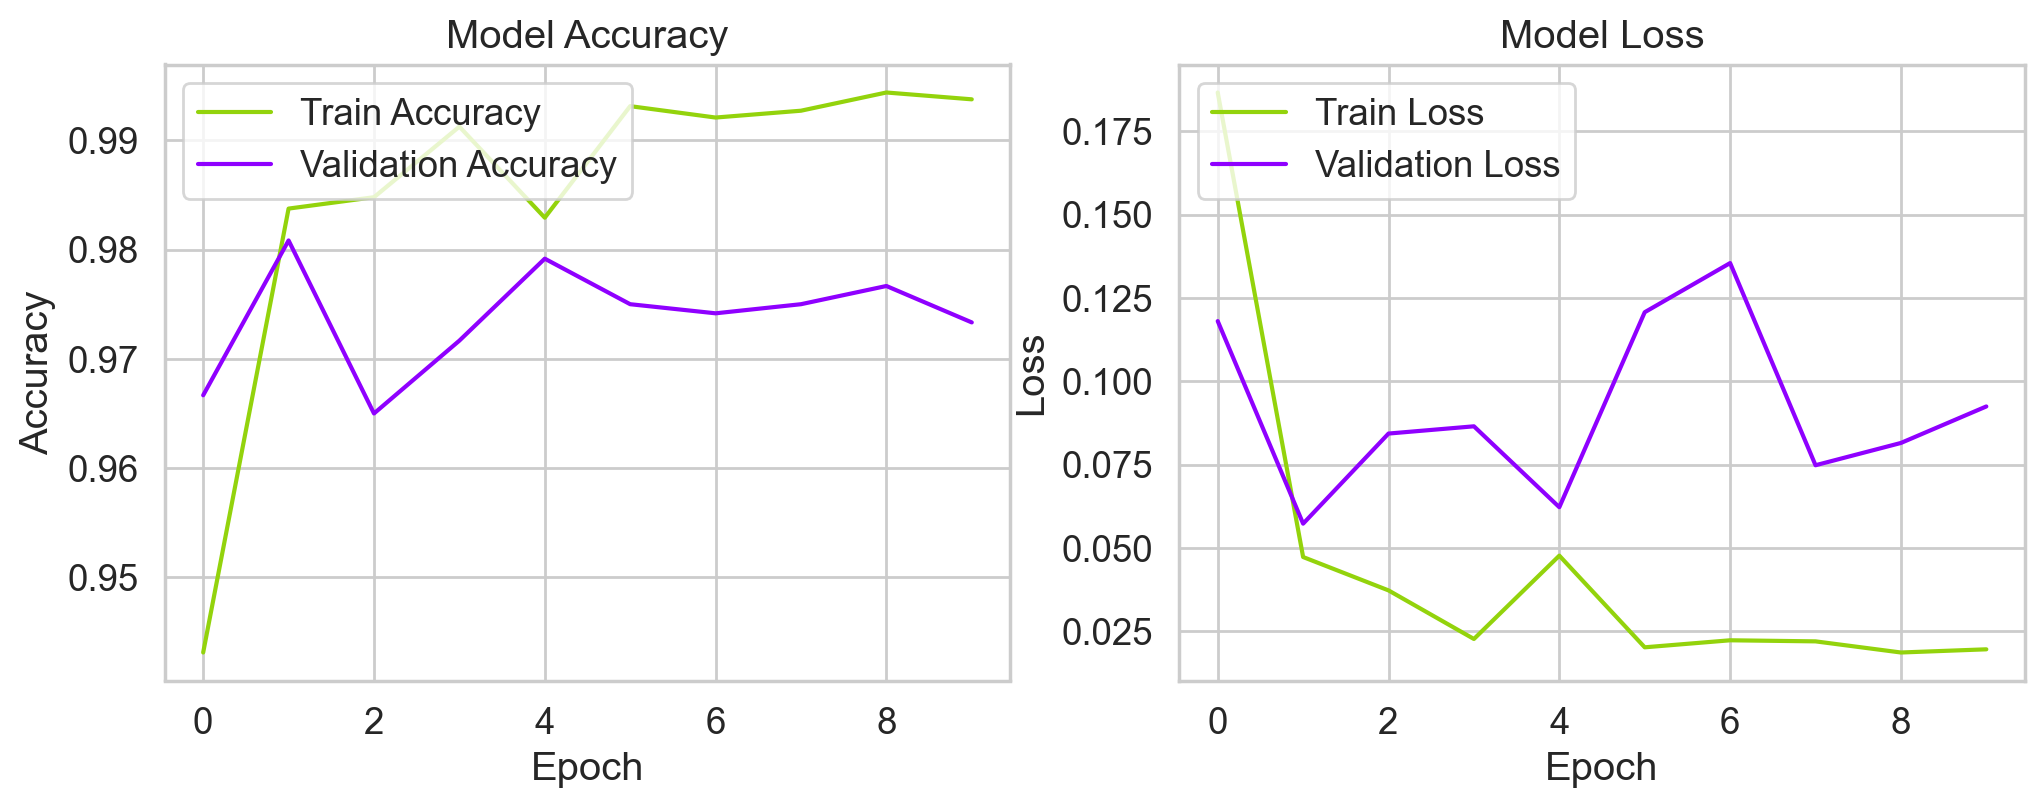

In [52]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()


In [8]:
modified_model = tf.keras.models.load_model("my_model.keras")

## Check test data

In [9]:
img_array = cv2.imread('train_2/closed_eyes/s0001_00018_0_0_0_0_0_01.png', cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb, (img_size, img_size))

In [10]:
X_input = np.array(new_array).reshape(1, img_size, img_size, 3)
X_input.shape

(1, 224, 224, 3)

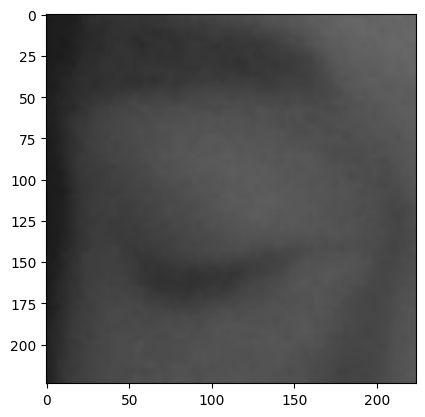

In [11]:
plt.grid(False)
plt.imshow(new_array)

In [12]:
X_input = X_input/255.0
prediction = modified_model.predict(X_input)
prediction

1/1 [==============================] - 0s 238ms/step


array([[9.9998903e-01, 1.1025803e-05]], dtype=float32)

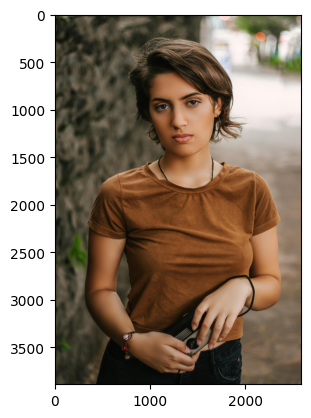

In [13]:
img = cv2.imread('test_img.jpg')
plt.grid(False)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Number of detected faces: 3


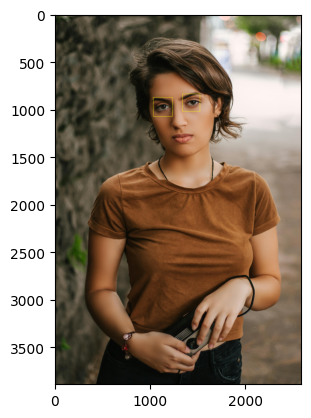

In [14]:
import cv2.data


faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = faceCascade.detectMultiScale(gray, 1.1, 4)
print('Number of detected faces:', len(faces))

for (x,y,w,h) in faces:
   roi_gray = gray[y:y+h, x:x+w]
   roi_color = img[y:y+h, x:x+w]
   
   # detects eyes of within the detected face 
   eyes = eye_cascade.detectMultiScale(roi_gray)
   
   # draw a rectangle around eyes
   for (ex,ey,ew,eh) in eyes:
      cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,255),2)

plt.grid(False)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

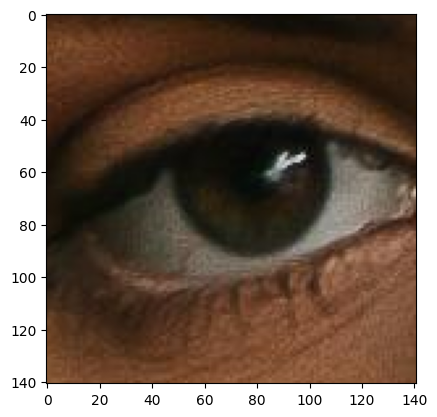

In [15]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)
for x,y,w,h in eyes:
    rol_gray = gray[y:y+h, x:x+w]
    rol_color = img[y:y+h, x:x+w]
    eyess = eye_cascade.detectMultiScale(rol_gray)
    if len(eyess) == 0:
        print("eyes are not detected")
    else:
        for (ex, ey, ew, eh) in eyess:
            eyes_rol = rol_color[ey: ey+eh, ex:ex+ew]
plt.grid(False)
plt.imshow(cv2.cvtColor(eyes_rol, cv2.COLOR_BGR2RGB))

In [18]:
final_image = cv2.resize(eyes_rol, (224, 224))
final_image = np.expand_dims(final_image, axis=0)
final_image = final_image/ 255
modified_model.predict(final_image)

1/1 [==============================] - 0s 18ms/step


array([[9.411711e-06, 9.999906e-01]], dtype=float32)

## Real time video detection

In [20]:
import pygame

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml')

cap = cv2.VideoCapture(1)
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

counter = 0
ALERT_THRESHOLD = 5
status = 'open'

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)

    eyes_detected = False
    for (x, y, w, h) in eyes:
        rol_gray = gray[y:y+h, x:x+w]
        rol_color = frame[y:y+h, x:x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        if len(rol_gray) > 0:
            eyes_detected = True
            final_image = cv2.resize(rol_color, (224, 224))
            final_image = np.expand_dims(final_image, axis=0)
            final_image = final_image / 255.0
            Predictions = modified_model.predict(final_image)

            font = cv2.FONT_HERSHEY_SIMPLEX
            if Predictions[0][1] > 0.5: 
                status = "Open Eyes"
                counter = 0
                cv2.putText(frame, status, (150, 150), font, 3, (0, 255, 0), 2, cv2.LINE_4)
                x1, y1, w1, h1 = 0, 0, 175, 75
                cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
                cv2.putText(frame, 'Active', (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
                # cv2.putText(frame, status, (150, 150), font, 3, (0, 255, 0), 2, cv2.LINE_4)
            else:
                counter += 1
                status = "Closed Eyes"
                cv2.putText(frame, status, (150, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)
                cv2.putText(frame, 'Drowsy', (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)


                if counter >= ALERT_THRESHOLD:
                    print('Sleepppp')
                    cv2.rectangle(frame, (0, 0), (175, 75), (0, 0, 0), -1)
                    cv2.putText(frame, 'Sleep Alert', (10, 50), font, 0.7, (0, 0, 255), 2)

                    # Play the sound
                    pygame.mixer.init()
                    sound = pygame.mixer.Sound('alert.wav')
                    sound.play()
                    pygame.time.wait(int(sound.get_length() * 1000))
                    counter = 0

    if not eyes_detected:
        counter = 0

    cv2.imshow("Drowsiness Detection", frame)

    if cv2.waitKey(2) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 18ms/step
Sleepppp
1/1 [==============================] - 0s 17ms/step


KeyboardInterrupt: 